# Computer Vision I (922 U0610) - Homework 7
Author: alanhc

ID: r10944007

Date: 10/27

## README
0. create env: `conda env create -f environment.yml`
1. enter env: `conda activate ntu-cv`
2. run jupyter `jupyter notebook`

Write a program which does thinning on a downsampled image (lena.bmp).
- Downsampling Lena from 512x512 to 64x64:
  - Binarize the benchmark image lena as in HW2, then using 8x8 blocks as a unit, take the topmost-left pixel as the downsampled data.
- You have to use 4-connected neighborhood detection.
- You can use any programing language to implement homework, however, you'll get zero point if you just call existing library.
- More detail about this homework. Download here-->PPT|PDF


<img src="img/alg.png" alt="drawing" width="50%"/>

image shape: (512, 512)


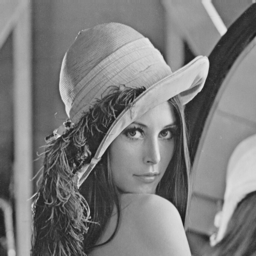

In [1]:
from PIL import Image
import numpy as np

# Todo: 讀檔，確定影像大小
img = Image.open("input/lena.bmp")
img = np.array(img)

h, w = img.shape

print("image shape:", img.shape)
show = Image.fromarray(img).resize((256,256))
show

(64, 64)


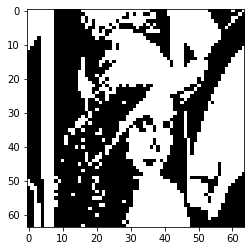

In [2]:
# Todo: sampling
## Hint: topmost-left: 左上角點可用//8求
# Algorithm:
## 1. 根據hint，先算出一個row/col有幾個sampling點，再用*8來還原sampling點在原本的位置
## 2. >127 來產生threshold 128的影像

## 512->64.  512/64=8
# 1.
ans = np.zeros((h//8,w//8))
for y in range(h//8):
    for x in range(w//8):
        # 1.
        if (img[y*8][x*8]>127):# 2. 
            ans[y][x] = 255

import matplotlib.pyplot as plt
print(ans.shape)
plt.imshow(ans, cmap="gray")
img_downSampling = ans

<img src="img/textbook-formula.png" alt="drawing" width="50%"/>

In [3]:
"""
index pixels
7 2 6 
3 0 1
8 4 5 
"""
# Todo: Yokoi connectivity numbe
# Algorithm:
## 1. 計算 h(a,b,c,d)，*程式為f_h* ，藉由三個coner點判斷類型 q,r,s，其中b,c,d,e為帶入的kernel點Xi
## 2. 計算 connectivity operator f(a1,a2,a3,a4)，其中a1,a2,a3,a4是由 h(x0,x1,x6,x2), h(x0,x2,x7,x3),  
##                                                                 h(x0,x3,x8,x4), h(x0,x4,x5,x1)
## 3. 根據課本式子參考上圖，計算5或n

def Yokoi(img):
    s_h, s_w = img.shape

    def index_values(img, y, x, n):
        # shift is a convert table reelated to index  textbook:x0,x1,x2...
        shift = {
            7:[-1,-1],
            2:[-1,0],
            6:[-1,1],
            3:[0,-1],
            0:[0,0],
            1:[0,1],
            8:[1,-1],
            4:[1,0],
            5:[1,1]
        }
        now_y = y+shift[n][0]
        now_x = x+shift[n][1]

        if (now_y>=0 and now_x>=0 and now_y<s_h and now_x<s_w):
            return img[ now_y ][ now_x ]
        else: 
            return 0

    # 1.
    def f_h(img, pos,b,c,d,e):
        y, x = pos

        b = index_values(img, y, x, b) 
        c = index_values(img, y, x, c)
        d = index_values(img, y, x, d)
        e = index_values(img, y, x, e)

        if (b==c and (d!=b or e!=b)):
            return "q"
        if (b==c and (d==b and e==b)):
            return "r"
        if (b!=c):
            return "s"
        else:
            print("=", b,c,d,e)

    def f(a1,a2,a3,a4):
        if (a1==a2 and a2==a3 and a3==a4 and a4=="r"):
            return 5
        s = str(a1+a2+a3+a4)
        ## 找{a1,a2,a3,a4}有幾個q
        ct=0
        for i in range(len(s)):
            if s[i]=="q":
                ct+=1
        return ct
    src = img
    ans = np.zeros((s_h, s_w))
    for y in range(s_h):
        for x in range(s_w):
            ## 2. 
            a1 = f_h(src, (y,x),0,1,6,2)
            a2 = f_h(src, (y,x),0,2,7,3)
            a3 = f_h(src, (y,x),0,3,8,4)
            a4 = f_h(src, (y,x),0,4,5,1)
            if (src[y][x]==0):
                continue
            ## 3.
            ans[y][x] = f(a1,a2,a3,a4)
    return ans

<img src="img/pair_relationship.png" alt="drawing" width="50%"/>

In [4]:
# Pair Relationship Operator
## 參考上面公式
## 1. 前面算出的yokoi對應到 h(a, 1)，代表點yokoi[y][x]==1
## 2. 判斷周圍點x1,x2,x3,x4，為標記p及q
def pair_relationship(yokoi):
    h, w = yokoi.shape
    #註： y-1>=0 | y+1<h 是邊界條件
    # 1.
    def h_P4(yokoi, y, x):
        if (y-1>=0 and yokoi[y-1][x  ]==1):
            return 1
        if (x-1>=0 and yokoi[y  ][x-1]==1):
            return 1
        if (y+1<h and yokoi[y+1][x  ]==1):
            return 1
        if (x+1<w and yokoi[y  ][x+1]==1):
            return 1
        return 0
    mark = np.zeros((h,w))
    for y in range(h):
        for x in range(w):
            # p = 1
            # q = 2
            # 2.
            if (yokoi[y][x]==0):
                mark[y][x] = 0
            elif (yokoi[y][x]==1 and h_P4(yokoi, y, x)==1):
                mark[y][x] = 2
            else:
                mark[y][x] = 1
            
    return mark

<img src="img/Connected_Shrink.png" alt="drawing" width="50%"/>

In [5]:
# Connected Shrink Operator & marked
## 參考上面公式
## 1. 根據 h(b, c, d, e)，找出yokoi corner
## 2. Connected Shrink Operator ，只有一個==1，可刪除
## 3. mark==2(p) && 是被2. 留下來的點
def marked_and_connected_shrink(img, img_mark):
    s_h, s_w = img.shape

    def index_values(img, y, x, n):
        # shift is a convert table reelated to index  textbook:x0,x1,x2...
        shift = {
            7:[-1,-1],
            2:[-1,0],
            6:[-1,1],
            3:[0,-1],
            0:[0,0],
            1:[0,1],
            8:[1,-1],
            4:[1,0],
            5:[1,1]
        }
        now_y = y+shift[n][0]
        now_x = x+shift[n][1]

        if (now_y>=0 and now_x>=0 and now_y<s_h and now_x<s_w):
            return img[ now_y ][ now_x ]
        else: 
            return 0

    # 1.
    def f_h(img, pos,b,c,d,e):
        y, x = pos

        b = index_values(img, y, x, b) 
        c = index_values(img, y, x, c)
        d = index_values(img, y, x, d)
        e = index_values(img, y, x, e)

        if (b==c and (b!=d or b!=e)):
            return 1
        else:
            return 0
    # Connected Shrink Operator
    def f(a1,a2,a3,a4, x0):
        if (a1+a2+a3+a4==1):
            return 0 # "g"
        return x0

    for y in range(s_h):
        for x in range(s_w):
            
            a1 = f_h(img, (y,x),0,1,6,2)
            a2 = f_h(img, (y,x),0,2,7,3)
            a3 = f_h(img, (y,x),0,3,8,4)
            a4 = f_h(img, (y,x),0,4,5,1)
            x0 = img[y][x]
            ## 2. 
            if (img_mark[y][x]==2):
                img[y][x] = f(a1,a2,a3,a4,x0)
    return img

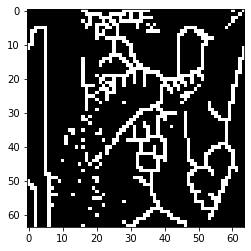

In [6]:
# 要做七次
for i in range(7):
    yokoi = Yokoi(img_downSampling)
    img_mark = pair_relationship(yokoi)
    img_downSampling = marked_and_connected_shrink(img_downSampling, img_mark)
plt.imshow(img_downSampling, cmap="gray")

Ref
- textbook

